In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import pickle
import matplotlib as mpl
import plotly.graph_objects as go

In [11]:
plt.rc("text", usetex=True)  # latex ticks
plt.rc("text.latex")
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
    }
)
plt.rcParams["axes.linewidth"] = 0.4
plt.rcParams["xtick.major.width"] = 0.4
plt.rcParams["xtick.minor.width"] = 0.2
plt.rcParams["ytick.major.width"] = 0.4
plt.rcParams["ytick.minor.width"] = 0.2

Slide_show_width = 4.71512
Paper_width = 6.30045
Format = 1
if Format == 0:
    Image_width = Slide_show_width
if Format == 1:
    Image_width = Paper_width

EXTRA_SMALL = 4
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 9

plt.rc("font", size=EXTRA_SMALL)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=EXTRA_SMALL)  # fontsize of the tick labels
plt.rc("ytick", labelsize=EXTRA_SMALL)  # fontsize of the tick labels
plt.rc("legend", fontsize=EXTRA_SMALL)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [12]:
results_dir = "RESULTS/DEVEL_RESULTS_l"
results_dirs = os.listdir(results_dir)

deliveries = np.unique(
    [int(dir_name.split("_427_")[1].split("_")[0]) for dir_name in results_dirs]
)

mae_results = {}
for delivery in deliveries:
    try:
        mae_results_delivery = pickle.load(
            open(f"RESULTS/MAE_ANALYSIS_FINAL/mae_results_60_{delivery}.pickle", "rb")
        )
        mae_results[delivery] = mae_results_delivery
    except:
        print(f"delivery {delivery} not found")

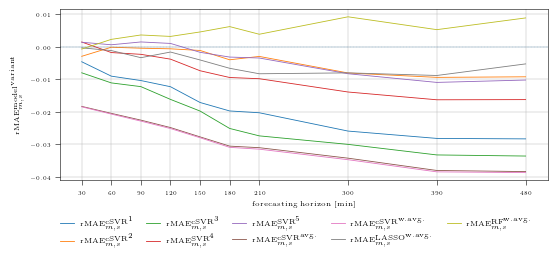

In [13]:
ttd = 0
fig, ax = plt.subplots(figsize=(Paper_width, 0.4 * Paper_width))

clean_kernel_names_map = {
    "naive": """na\"{\i}ve""",
    "prediction_1": "$\mathrm{rMAE}^{\mathrm{cSVR}^1}_{m,s}$",
    "prediction_2": "$\mathrm{rMAE}^{\mathrm{cSVR}^2}_{m,s}$",
    "prediction_7": "$\mathrm{rMAE}^{\mathrm{cSVR}^3}_{m,s}$",
    "prediction_plain_laplace_L2": "$\mathrm{\mathrm{rMAE}}^{\mathrm{SVR}^4}_{m,s}$",
    "prediction_plain_laplace": "$\mathrm{\mathrm{rMAE}}^{\mathrm{SVR}^5}_{m,s}$",
    "avg_1_2_7_naive": "$\mathrm{rMAE}^{\mathrm{cSVR}^{\mathrm{avg.}}}_{m,s}$",
    "prediction_32": "$\mathrm{rMAE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$",
    "prediction_32lasso": "$\mathrm{rMAE}^{\mathrm{LASSO}^{\mathrm{w. avg.}}}_{m,s}$",
    "prediction_32random_forest": "$\mathrm{rMAE}^{\mathrm{RF}^{\mathrm{w. avg.}}}_{m,s}$",
}

worse_performing_models = {
    "prediction_33": "intel avg. 1,2,7 win 14",
    "prediction_34": "intel avg. 1,2,7 win 21",
    "prediction_35": "intel avg. 1,2,7 win 28",
    "predictionlasso": "$\hat{P}_{LASSO}^{1}$",
    "prediction_closelasso": "$\hat{P}_{LASSO}^{2}$",
    "prediction_exoglasso": "$\hat{P}_{LASSO}^{3}$",
    "predictionrandom_forest": "$\hat{P}_{RF}^{1}$",
    "prediction_closerandom_forest": "$\hat{P}_{RF}^{2}$",
    "prediction_exograndom_forest": "$\hat{P}_{RF}^{3}$",
}

avgs_table = pd.DataFrame()

for var_set in [11]:
    for forecast_technique in list(clean_kernel_names_map.keys()) + list(
        worse_performing_models.keys()
    ):
        results = {}
        counter_dict = {}
        for delivery in mae_results.keys():
            for horizon in [480, 390, 300, 210, 180, 150, 120, 90, 60, 30]:
                if horizon in mae_results[delivery].keys():
                    if not (horizon in results.keys()):
                        results[horizon] = 0
                        counter_dict[horizon] = 0
                    # choose the trade time
                    trade_times = []
                    for trad in mae_results[delivery][horizon].keys():
                        if len(mae_results[delivery][horizon][trad]) > 0:
                            trade_times.append(trad)
                    trade_time = trade_times[ttd]
                    if (
                        len(mae_results[delivery][horizon][trade_time]) > 0
                        and "naive" in mae_results[delivery][horizon][trade_time].keys()
                    ):
                        results[horizon] += mae_results[delivery][horizon][trade_time][
                            forecast_technique
                        ]
                        counter_dict[horizon] += 1

        results_plot = []
        for horizon in [480, 390, 300, 210, 180, 150, 120, 90, 60, 30]:
            if horizon == 30 and counter_dict[horizon] != 96:
                print(delivery)

            if counter_dict[horizon] == 0:
                results_plot.append(np.nan)
            else:
                results_plot.append(results[horizon] / counter_dict[horizon])

        if forecast_technique != "naive":
            if forecast_technique in list(clean_kernel_names_map.keys()):
                ax.plot(
                    [480, 390, 300, 210, 180, 150, 120, 90, 60, 30],
                    (np.array(results_plot) - np.array(naive_results))
                    / np.array(naive_results),
                    label=clean_kernel_names_map[forecast_technique],
                    lw=0.6,
                )
                avgs_table[clean_kernel_names_map[forecast_technique]] = [
                    np.mean(
                        (np.array(results_plot) - np.array(naive_results))
                        / np.array(naive_results)
                    )
                ]
            else:
                avgs_table[worse_performing_models[forecast_technique]] = [
                    np.mean(
                        (np.array(results_plot) - np.array(naive_results))
                        / np.array(naive_results)
                    )
                ]

        else:
            naive_results = results_plot

        if forecast_technique == "prediction_32lasso":
            lasso_avg_mae = results_plot

ax.axhline(0, ls="--", lw=0.2)
ax.set_xlabel("forecasting horizon [min]")
# ax.set_ylabel("avg. $(MAE_{model} - MAE_{naive})/MAE_{naive}$")
ax.set_ylabel("$\mathrm{rMAE}^{\mathrm{model}^\mathrm{variant}}_{m,s}$")
fig.legend(
    loc="outside lower center",
    ncol=5,
    frameon=False,
    bbox_to_anchor=(0.5, -0.09),
    fontsize=5,
)

ax.set_xticks([480, 390, 300, 210, 180, 150, 120, 90, 60, 30])
ax.grid(visible=True, linewidth=0.3)

fig.autofmt_xdate(rotation=0, ha="center")
# fig.subplots_adjust(bottom=0.3) # or whatever
plt.savefig("../Paper_Figures/relative_MAE_all_models.pdf", bbox_inches="tight")

avgs_table.to_csv("relative_mae_table.csv")

In [14]:
avgs_table

,"$\mathrm{rMAE}^{\mathrm{cSVR}^1}_{m,s}$","$\mathrm{rMAE}^{\mathrm{cSVR}^2}_{m,s}$","$\mathrm{rMAE}^{\mathrm{cSVR}^3}_{m,s}$","$\mathrm{\mathrm{rMAE}}^{\mathrm{SVR}^4}_{m,s}$","$\mathrm{\mathrm{rMAE}}^{\mathrm{SVR}^5}_{m,s}$","$\mathrm{rMAE}^{\mathrm{cSVR}^{\mathrm{avg.}}}_{m,s}$","$\mathrm{rMAE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$","$\mathrm{rMAE}^{\mathrm{LASSO}^{\mathrm{w. avg.}}}_{m,s}$","$\mathrm{rMAE}^{\mathrm{RF}^{\mathrm{w. avg.}}}_{m,s}$","intel avg. 1,2,7 win 14","intel avg. 1,2,7 win 21","intel avg. 1,2,7 win 28",$\hat{P}_{LASSO}^{1}$,$\hat{P}_{LASSO}^{2}$,$\hat{P}_{LASSO}^{3}$,$\hat{P}_{RF}^{1}$,$\hat{P}_{RF}^{2}$,$\hat{P}_{RF}^{3}$
0,-0.017604,-0.003911,-0.021686,-0.00797,-0.003345,-0.028633,-0.028957,-0.004773,0.004618,-0.028985,-0.028955,-0.028931,0.065175,0.021344,0.003351,0.040961,0.049845,0.046169


Plot of MAE and relative MAE for all lead times:

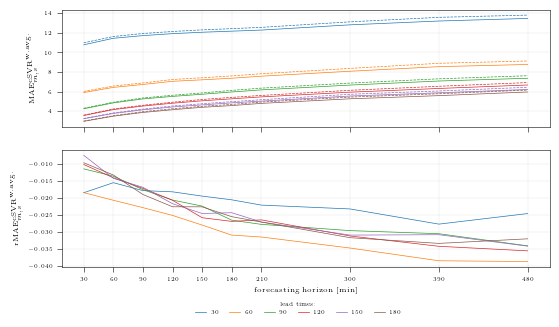

In [15]:
plot_matrix = []
ttd = 0
results_dir = "RESULTS/DEVEL_RESULTS_l"
results_dirs = os.listdir(results_dir)

deliveries = np.unique(
    [int(dir_name.split("_427_")[1].split("_")[0]) for dir_name in results_dirs]
)

for trade_vs_delivery_delta in [30, 60, 90, 120, 150, 180]:
    mae_results = {}
    for delivery in deliveries:
        try:
            mae_results_delivery = pickle.load(
                open(
                    f"RESULTS/MAE_ANALYSIS_FINAL/mae_results_{trade_vs_delivery_delta}_{delivery}.pickle",
                    "rb",
                )
            )
            mae_results[delivery] = mae_results_delivery
        except:
            print(
                f"delivery {delivery}, delivery - trade {trade_vs_delivery_delta} not found"
            )

    var_set = 11
    for forecast_technique in ["naive", "prediction_32"]:
        results = {}
        counter_dict = {}
        for delivery in mae_results.keys():
            for horizon in [480, 390, 300, 210, 180, 150, 120, 90, 60, 30][::-1]:
                if horizon in mae_results[delivery].keys():
                    if not (horizon in results.keys()):
                        results[horizon] = 0
                        counter_dict[horizon] = 0
                    # choose the trade time
                    trade_times = []
                    for trad in mae_results[delivery][horizon].keys():
                        if len(mae_results[delivery][horizon][trad]) > 0:
                            trade_times.append(trad)
                    trade_time = trade_times[ttd]
                    if (
                        len(mae_results[delivery][horizon][trade_time]) > 0
                        and "naive" in mae_results[delivery][horizon][trade_time].keys()
                    ):
                        results[horizon] += mae_results[delivery][horizon][trade_time][
                            forecast_technique
                        ]
                        counter_dict[horizon] += 1

        results_plot = []
        for horizon in [480, 390, 300, 210, 180, 150, 120, 90, 60, 30][::-1]:
            if counter_dict[horizon] == 0:
                results_plot.append(np.nan)
            else:
                results_plot.append(results[horizon] / counter_dict[horizon])

        if forecast_technique != "naive":
            plot_matrix.append(
                (np.array(results_plot) - np.array(naive_results))
                / np.array(naive_results)
            )
        else:
            naive_results = results_plot

plot_matrix_naive = []
plot_matrix_model = []

ttd = 0
results_dir = "RESULTS/DEVEL_RESULTS_l"
results_dirs = os.listdir(results_dir)

deliveries = np.unique(
    [int(dir_name.split("_427_")[1].split("_")[0]) for dir_name in results_dirs]
)

for trade_vs_delivery_delta in [30, 60, 90, 120, 150, 180]:
    mae_results = {}
    for delivery in deliveries:
        try:
            mae_results_delivery = pickle.load(
                open(
                    f"RESULTS/MAE_ANALYSIS_FINAL/mae_results_{trade_vs_delivery_delta}_{delivery}.pickle",
                    "rb",
                )
            )
            mae_results[delivery] = mae_results_delivery
        except:
            print(
                f"delivery {delivery}, delivery - trade {trade_vs_delivery_delta} not found"
            )

    var_set = 11
    for forecast_technique in ["naive", "prediction_32"]:
        results = {}
        counter_dict = {}
        for delivery in mae_results.keys():
            for horizon in [480, 390, 300, 210, 180, 150, 120, 90, 60, 30][::-1]:
                if horizon in mae_results[delivery].keys():
                    if not (horizon in results.keys()):
                        results[horizon] = 0
                        counter_dict[horizon] = 0
                    # choose the trade time
                    trade_times = []
                    for trad in mae_results[delivery][horizon].keys():
                        if len(mae_results[delivery][horizon][trad]) > 0:
                            trade_times.append(trad)
                    trade_time = trade_times[ttd]
                    if (
                        len(mae_results[delivery][horizon][trade_time]) > 0
                        and "naive" in mae_results[delivery][horizon][trade_time].keys()
                    ):
                        results[horizon] += mae_results[delivery][horizon][trade_time][
                            forecast_technique
                        ]
                        counter_dict[horizon] += 1

        results_plot = []
        for horizon in [480, 390, 300, 210, 180, 150, 120, 90, 60, 30][::-1]:
            if counter_dict[horizon] == 0:
                results_plot.append(np.nan)
            else:
                results_plot.append(results[horizon] / counter_dict[horizon])

        if forecast_technique != "naive":
            plot_matrix_model.append(np.array(results_plot))
        else:
            plot_matrix_naive.append(np.array(results_plot))

fig, axs = plt.subplots(nrows=2, figsize=(Paper_width, 0.6 * Paper_width))

labels = [30, 60, 90, 120, 150, 180]
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

ax = axs[0]
for horizon in range(np.shape(plot_matrix_model)[0]):
    ax.plot(
        [480, 390, 300, 210, 180, 150, 120, 90, 60, 30][::-1],
        plot_matrix_model[horizon],
        lw=0.5,
        color=colors[horizon],
    )
    ax.plot(
        [480, 390, 300, 210, 180, 150, 120, 90, 60, 30][::-1],
        plot_matrix_naive[horizon],
        "--",
        lw=0.5,
        color=colors[horizon],
    )

ax.set_xlabel("forecasting horizon [min]")
ax.set_ylabel("$\mathrm{MAE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$")

ax.set_xticks([480, 390, 300, 210, 180, 150, 120, 90, 60, 30][::-1])
ax.grid(visible=True, linewidth=0.1)

ax = axs[1]
for horizon in range(np.shape(plot_matrix)[0]):
    ax.plot(
        [480, 390, 300, 210, 180, 150, 120, 90, 60, 30][::-1],
        plot_matrix[horizon],
        lw=0.5,
        label=labels[horizon],
        color=colors[horizon],
    )

ax.set_xlabel("forecasting horizon [min]")
ax.set_ylabel(" $\mathrm{rMAE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$")
fig.legend(
    loc="outside lower center",
    ncol=6,
    frameon=False,
    bbox_to_anchor=(0.5, 0.06),
    title="lead times:",
)

ax.set_xticks([480, 390, 300, 210, 180, 150, 120, 90, 60, 30][::-1])
ax.grid(visible=True, linewidth=0.1)

fig.autofmt_xdate(rotation=0, ha="center")
plt.savefig(
    "../Paper_Figures/naive_and_best_model_MAE_and_relative_MAE.pdf",
    bbox_inches="tight",
)

3D plot of relative MAE:

In [16]:
mae_results = {}
for delivery in deliveries:
    try:
        mae_results_delivery = pickle.load(
            open(f"RESULTS/MAE_ANALYSIS_FINAL/mae_results_60_{delivery}.pickle", "rb")
        )
        mae_results[delivery] = mae_results_delivery
    except:
        print(f"delivery {delivery} not found")

In [17]:
results_matrix = pd.DataFrame()
col_chosen = "prediction_32"

for d, delivery in enumerate(mae_results.keys()):
    for h, horizon in enumerate([480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30]):
        if horizon in mae_results[delivery].keys():
            # choose the trade time
            trade_times = []
            for trad in mae_results[delivery][horizon].keys():
                if len(mae_results[delivery][horizon][trad]) > 0:
                    trade_times.append(trad)
            trade_time = trade_times[0]
            if (
                len(mae_results[delivery][horizon][trade_time]) > 0
                and "naive" in mae_results[delivery][horizon][trade_time].keys()
                and mae_results[delivery][horizon][trade_time]["naive"]
            ):
                results_matrix.loc[horizon, delivery * 0.25] = (
                    mae_results[delivery][horizon][trade_time][col_chosen]
                    - mae_results[delivery][horizon][trade_time]["naive"]
                ) / mae_results[delivery][horizon][trade_time]["naive"]
results_matrix = results_matrix.sort_index()

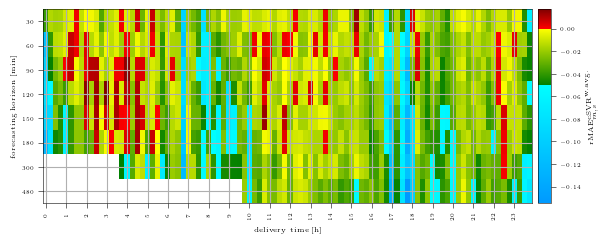

In [18]:
import matplotlib as mpl
import matplotlib.ticker as mtick

results_matrix = results_matrix.sort_index()

partition = 1000
green_part = int(
    0.05
    / (-np.nanmin(results_matrix.to_numpy()) + np.nanmax(results_matrix.to_numpy()))
    * partition
)
red_part = int(
    np.nanmax(results_matrix.to_numpy())
    / (-np.nanmin(results_matrix.to_numpy()) + np.nanmax(results_matrix.to_numpy()))
    * partition
)
blue_part = int(partition - green_part - red_part)

red = np.concatenate(
    [
        np.zeros(blue_part),
        np.linspace(0, 1, green_part),
        np.linspace(1, 0.5, red_part + 1)[1:],
    ]
)
green = np.concatenate(
    [
        np.linspace(0.6, 1, blue_part),
        np.linspace(0.5, 1, green_part),
        np.zeros(red_part),
    ]
)
blue = np.concatenate([np.ones(blue_part), np.zeros(green_part), np.zeros(red_part)])
rgb_color_map = np.concatenate(
    [red.reshape(-1, 1), green.reshape(-1, 1), blue.reshape(-1, 1)], axis=1
)
rgb_color_map = mpl.colors.ListedColormap(rgb_color_map)

fig, ax = plt.subplots(figsize=(Image_width, 0.4 * Image_width))
im = ax.imshow(
    results_matrix.astype(float).values,
    cmap=rgb_color_map,
    vmin=np.nanmin(results_matrix.to_numpy()),
    vmax=np.nanmax(results_matrix.to_numpy()),
    aspect="auto",
)
ax.set_xticks(
    range(len(results_matrix.columns)),
    [int(i) for i in results_matrix.columns],
    rotation=90.0,
)
ax.set_yticks(range(len(results_matrix.index)), results_matrix.index)
ax.set_xlabel("delivery time [h]")
ax.set_ylabel("forecasting horizon [min]")
ax.xaxis.set_major_locator(mtick.MultipleLocator(4))
ax.grid(True)
fig.subplots_adjust(right=0.9)
ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1 + 0.01, ax_pos.y0, 0.02, ax_pos.y1 - ax_pos.y0])
fig.colorbar(
    im,
    cax=cbar_ax,
    pad=0.5,
    shrink=0.4,
    label="$\mathrm{rMAE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$",
)
# cbar.set_label('# of contacts', rotation=270)

# Loop over data dimensions and create text annotations.
# for i_idx, i in enumerate(results_matrix.index):
#     for j_idx, j in enumerate(results_matrix.columns):
#         text = ax.text(j_idx, i_idx, results_matrix.loc[i, j].round(2),
#                        ha="center", va="center", color="w")
plt.savefig(
    "../Paper_Figures/3D_relative_mae_traded_60min_before_delivery.pdf",
    bbox_inches="tight",
)

# DM test

DM:
         0.00      0.25      0.50      0.75      1.00      1.25      1.50   \
30   0.412514  0.181877  0.356598  0.000158  0.021255  0.122949  0.037919   
60   0.221672  0.725820  0.551491  0.007598  0.045261  0.551141  0.150425   
90   0.009128  0.305751  0.598196  0.006145  0.032955  0.308787  0.786170   
120  0.001126  0.058653  0.308821  0.048148  0.165277  0.340252  0.768700   
150  0.000526  0.164176  0.296701  0.031557  0.013416  0.149419  0.258706   
180  0.000084  0.034972  0.400554  0.010552  0.083343  0.064006  0.038907   
300       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
480       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

        1.75      2.00      2.25   ...     21.50     21.75     22.00  \
30   0.001437  0.587693  0.143273  ...  0.010061  0.023271  0.446693   
60   0.002179  0.503914  0.719464  ...  0.178097  0.277963  0.745693   
90   0.009855  0.572633  0.375208  ...  0.429553  0.010781  0.181803   
120  0.015714

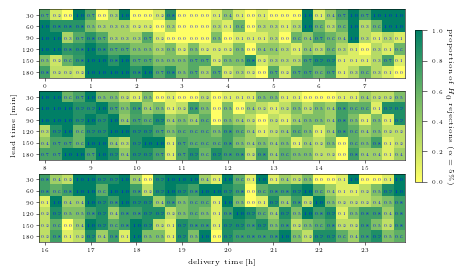

In [19]:
col_chosen = "prediction_32_DM_wrt_naive_pval"
import matplotlib as mpl
import matplotlib.ticker as mtick

aggregated_DM_results = []

for trade_horizon in range(30, 210, 30):
    mae_results = {}
    for delivery in deliveries:
        try:
            mae_results_delivery = pickle.load(
                open(
                    f"RESULTS/MAE_ANALYSIS_FINAL/mae_results_{trade_horizon}_{delivery}.pickle",
                    "rb",
                )
            )
            mae_results[delivery] = mae_results_delivery
        except:
            print(
                f"delivery {delivery}, delivery - trade {trade_vs_delivery_delta} not found"
            )
    results_matrix = pd.DataFrame()
    mae_results_matrix = pd.DataFrame()
    for d, delivery in enumerate(mae_results.keys()):
        for h, horizon in enumerate(
            [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30]
        ):
            if horizon in mae_results[delivery].keys():
                # choose the trade time
                trade_times = []
                for trad in mae_results[delivery][horizon].keys():
                    if len(mae_results[delivery][horizon][trad]) > 0:
                        trade_times.append(trad)
                trade_time = trade_times[0]
                if len(mae_results[delivery][horizon][trade_time]) > 0:
                    results_matrix.loc[horizon, delivery * 0.25] = mae_results[
                        delivery
                    ][horizon][trade_time][col_chosen]
                    mae_results_matrix.loc[horizon, delivery * 0.25] = (
                        mae_results[delivery][horizon][trade_time]["prediction_32"]
                        - mae_results[delivery][horizon][trade_time]["naive"]
                    ) / mae_results[delivery][horizon][trade_time]["naive"]
    results_matrix = results_matrix.sort_index()
    mae_results_matrix = mae_results_matrix.sort_index()
    print("DM:\n", results_matrix)
    print("MAE:\n", mae_results_matrix)
    aggregated_DM_results.append(
        np.nansum(0.05 >= results_matrix.to_numpy(), axis=0)
        / np.sum(~np.isnan(results_matrix.to_numpy()), axis=0)
    )

# draw in three subplots
fig, axs = plt.subplots(nrows=3, figsize=(0.8 * Image_width, 0.8 * 0.6 * Image_width))
fig.subplots_adjust(hspace=0.2)
for i in range(3):
    dm_results_df = pd.DataFrame(
        columns=list(results_matrix.columns)[i * 32 : (i + 1) * 32],
        index=range(30, 210, 30),
        data=np.vstack(aggregated_DM_results)[:, i * 32 : (i + 1) * 32],
    )
    ax = axs[i]
    im = ax.imshow(
        dm_results_df.astype(float).values,
        cmap="summer_r",
        vmin=np.nanmin(dm_results_df.to_numpy()),
        vmax=np.nanmax(dm_results_df.to_numpy()),
        aspect="auto",
    )
    ax.set_xticks(
        range(len(dm_results_df.columns)), [int(i) for i in dm_results_df.columns]
    )
    ax.set_yticks(range(len(dm_results_df.index)), dm_results_df.index)
    ax.tick_params(axis="both", length=2, pad=2)
    if i == 2:
        ax.set_xlabel("delivery time [h]")
    if i == 1:
        ax.set_ylabel("lead time [min]")
    ax.xaxis.set_major_locator(mtick.MultipleLocator(4))
    # ax.grid(True)
    fig.subplots_adjust(right=0.9)

    # Loop over data dimensions and create text annotations.
    for j_idx, j in enumerate(dm_results_df.index):
        for k_idx, k in enumerate(list(dm_results_df.columns)):
            text = ax.text(
                k_idx,
                j_idx,
                dm_results_df.loc[j, k].round(1),
                ha="center",
                va="center",
                color="b",
                fontsize=3,
            )
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.31, 0.015, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(
    "proportion of $H_0$ rejections ($\\alpha = 5\%$)", rotation=270, labelpad=8
)
plt.savefig("../Paper_Figures/all_horizons_DM_results.pdf", bbox_inches="tight")

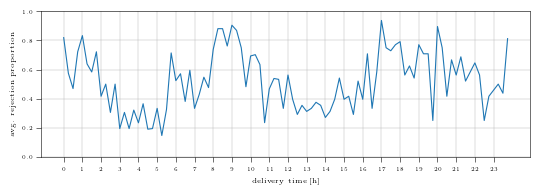

In [20]:
dm_results_df_total = pd.DataFrame(
    columns=list(results_matrix.columns),
    index=range(30, 210, 30),
    data=np.vstack(aggregated_DM_results),
)

fig, ax = plt.subplots(figsize=(Image_width, 0.3 * Image_width))
ax.plot(dm_results_df_total.columns, dm_results_df_total.mean().values, lw=0.8)
ax.set_xticks(range(24))
ax.grid(visible=True, linewidth=0.3)
# ax.axhline(0.5, ls='--', lw=0.4, color='black')
ax.set_xlabel("delivery time [h]")
ax.set_ylabel("avg. rejection proportion")
ax.set_ylim(0, 1)
plt.savefig("../Paper_Figures/avg_rejections_proportion.pdf", bbox_inches="tight")